# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2025

----
### Contexte
Le béton est le matériau le plus important en génie civil. La résistance à la compression du béton est une fonction fortement non linéaire de son âge et de ses constituants. Ces constituants comprennent le ciment, le laitier de haut fourneau, les cendres volantes, l’eau, le superplastifiant, les gros granulats et les granulats fins.

Vous avez accès à une vraie banque de données répertoriant la résistance à la compression du béton en fonction de ses constituants. Ces données ont déjà été analysées avec des réseaux de neurones dans plusieurs articles scientifiques, notamment Chen (1998).

### Objectif
L'objectif principal est de développer un modèle statistique permettant la prédiction de la résistance à la compression (**Strength**) des 330 recettes de l'ensemble de test, en fonction de leurs caractéristiques et de leur âge.

### Description des Données
Les données sont réparties en deux fichiers :
- `train.csv` : 700 recettes avec la résistance connue (Ensemble d'entraînement).
- `test.csv` : 330 recettes dont la résistance est à prédire.

# **1. Chargement des données**
Importation des librairies nécessaires à l'analyse et à la modélisation.

In [15]:
using CSV, DataFrames, Statistics, Plots, LinearAlgebra, Random, Measures

default(size=(800, 500), margin=5Plots.mm)

## 1.1 Chargement des données d'entraînement et de test
Nous chargeons les fichiers CSV dans des DataFrames pour faciliter la manipulation.

In [16]:
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

println("Dimensions Train : ", size(train_df))
println("Dimensions Test  : ", size(test_df))

first(train_df, 5)

Dimensions Train : (700, 10)
Dimensions Test  : (330, 9)


Row,ID,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
2,2,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.78
3,3,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.83
4,4,183.9,122.6,0.0,203.5,0.0,959.2,800.0,3,4.9
5,5,385.0,0.0,0.0,186.0,0.0,966.0,763.0,1,6.27


## 1.2 Vérification de la qualité des données
Nous vérifions s'il existe des valeurs manquantes qui pourraient fausser l'analyse. Nous voyons qu'il n'y a aucune donnée manquante. (nmissing = 0 pour toutes les variables). Alors, nous n'avons pas de traitement de données à faire par rapport à cela.

In [3]:
describe(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,ID,350.5,1,350.5,700,0,Int64
2,Cement,283.868,102.0,277.0,540.0,0,Float64
3,Slag,74.8664,0.0,24.0,359.4,0,Float64
4,Ash,53.7016,0.0,0.0,200.0,0,Float64
5,Water,181.207,121.8,185.0,246.9,0,Float64
6,Superplasticizer,6.24386,0.0,6.5,32.2,0,Float64
7,Coarse,973.72,801.0,968.0,1145.0,0,Float64
8,Fine,772.727,594.0,778.5,992.6,0,Float64
9,Age,44.9,1,28.0,365,0,Int64


----


# **2. Exploration des données**




Avant de commenecr la modélisation, la visualisation des données constitue une étape essentielle pour comprendre la structure du jeu de données et identifier les relations potentielles entre variables. 

En particulier, cette démarche nous permet de repérer d’éventuelles tendances, des zones de dispersion ou regroupements naturels. Cela nous permet d'avoir un premier aperçu des mécanismes susceptibles d’influencer la variable cible. 

### **2.1 Visualisation de chaque feature en fonction de la variable cible**




Nous commençons par examiner la distribution de chaque feature en fonction de la variable cible. Ceci nous permet d’identifier la nature des relations qui les lient : linéaires, non linéaires  ou au contraire inexistantes. 

L'idée ici est de récupérer le plus d'informations sur des zones de variabilité différentielle, des seuils possibles, ou alors des comportements atypiques pouvant influencer la performance du modèle. Autrement dit, cette analyse nous permet de mieux anticiper la pertinence prédictive de chaque variable etde détecter d’éventuelles transformations nécessaires (normalisation, logarithme, etc.).

In [ ]:
function plot_features_vs_target(train_df, target_col)
    features = names(train_df)[2:end-1]  # pour exclure ID et Strength
    n_features = length(features)
    
    plots = []    
    for feature in features
        p = scatter(train_df[!, feature], train_df[!, target_col],
                  xlabel=feature, ylabel=target_col,
                  title="$feature vs $target_col",
                  markersize=4, alpha=0.5,
                  legend=false)
        push!(plots, p)
    end

    plot_grid = plot(plots..., layout=(ceil(Int, n_features/3), 3), size=(1300, 1100),
                   left_margin=4mm,
                   right_margin=4mm,
                   top_margin=10mm,
                   bottom_margin=10mm)
    display(plot_grid)
end

plot_features_vs_target(train_df, "Strength")

Pour analyser de plus près les différentes tendances, on analyse la corrélation de chaque attribut avec la variable cible.

In [ ]:
function analyze_strength_correlations(train_df)
    features = names(train_df)[2:end-1] 
    correlations = Float64[]    
    for feature in features
        cor_val = cor(train_df[!, feature], train_df.Strength)
        push!(correlations, cor_val)
    end
    
    cor_df = DataFrame(Feature=features, Correlation=correlations)
    sort!(cor_df, :Correlation, rev=true)
    
    println("\nCorrélations avec Strength (triées) :")
    for row in eachrow(cor_df)
        println("$(row.Feature): $(round(row.Correlation, digits=3))")
    end
    
    # graphique des corrélations
    bar_plot = Plots.bar(cor_df.Feature, cor_df.Correlation,
        xlabel="Features", ylabel="Corrélation avec Strength",
        title="Corrélations des features avec Strength",
        legend=false, xrotation=45,
        color=ifelse.(cor_df.Correlation .> 0, :blue, :red),
        size=(800, 400))
    
    
    return bar_plot
end

cor_bar_plot = analyze_strength_correlations(train_df)

### **2.2 Interprétation des relations : Composants vs. Strength**

En examinant les diagrammes de dispersion pour chaque variable explicative, nous tirons les observations suivantes concernant leur relation avec la **Force (Strength)** du béton :

| Variable | Type relation avec Force | Tendances clés |
| :--- | :--- | :--- |
| **Ciment** | Corrélation positive | Augmentation de la Force en moyenne avec l'augmentation du Ciment. La dispersion verticale (variation de la Force) est assez large pour la plupart des niveaux de Ciment|
| **Age** | Corrélation positive | Augmentation de la Force significative avec l'augmentation de l'Âge (jusqu'à environ 100 jours). |
| **Water** | Corrélation négative modérée | Diminution de la Force en moyenne avec l'augmentation de la quantité d'Eau. |
| **Slag** | Complexe / non-linéaire | Dispersion élevée, les Forces les plus élevées sont atteintes à des valeurs de Slag faibles à modérées. |
| **Ash** | Faible / nulle | Très forte dispersion, les Forces les plus élevées sont atteintes uniquement lorsque l'Ash est faible. |
| **Superplasticizer** | Complexe / non-linéaire | Forte concentration à zéro, les Forces les plus élevées sont atteintes à des doses faibles à modérées (entre 5 et 20). |
| **Fine** | Faible / légèrement négative | Très forte dispersion sans tendance claire. |
| **Coarse** | Nulle | Très forte dispersion sans tendance claire. |








#### Dégagement d'une première piste de recherche grâce à cette visualisation : vers le Feature Engineering

##### 1. Création de variables booléennes :

L'analyse des distributions des varaibles **Slag, Ash et Superplasticizer** révèle une caractéristique commune notable : une **concentration élevée de valeurs à zéro** sur l'axe des x. Cette masse de points à l'origine suggère qu'une portion significative des recettes de béton enregistrées n'inclut pas ces additifs. 
* Ainsi, les variables avec une forte concentration de valeurs à zéro masquent une information binaire cruciale : la recette inclut-elle l'additif ou non ?
Cette observation nous donne une première piste de réflexion : au  lieu de considérer uniquement la quantité continue de ces attributs, il pourrait être très pertinent de **les transformer en variables booléennes** (ou binaires).

##### 2. Variables indiquant un besoin de transformation (non-linéarité) :

Pour **apréhender la modélisation des relations complexes** comme celle de l'âge avec la force, nous devons appliquer des **transformations non linéaires**. L'objectif est de rendre ces relations plus linéaires si nous voulons utiliser des algorithmes classiques par la suite.

* Pour l'Âge, dont l'effet diminue avec le temps (saturation), la méthode la plus appropriée est la transformation logarithmique ($\log(\text{Âge})$) : elle compresse les grandes valeurs et étire les petites, normalisant ainsi le taux de gain de Force. Une autre approche clé est la discrétisation (Binning), qui consiste à segmenter la variable en intervalles, ce qui pourrait permettre au modèle de mieux apprendre les différents paliers de prise de Force spécifiques aux normes de construction. 

* Les transformations polynomiales (ex : $X^2$) peuvent être utiles pour capturer des courbures subtiles ou alors des effets de seuil dans des variables comme le ciment. 

On explorera ces différentes pistes par la suite.

### **2.3 Détection des valeurs suspectes**

La présence de données aberrantes (*outliers*) peut gravement nuire à la qualité d'un modèle de régression, car la méthode des moindres carrés est très sensible aux valeurs extrêmes.

Comme vu au **Chapitre 2 (Section 2.7.5 - Identification des données suspectes)**, nous utilisons les **résidus studentisés** ($s_i$) pour identifier ces observations.

#### 2.3.1 Méthodologie Théorique

Le résidu studentisé interne est défini par :
$$s_i = \frac{e_i}{\sqrt{\hat{\sigma}^2 (1 - h_i)}}$$

Où :
* $e_i = y_i - \hat{y}_i$ est le résidu ordinaire.
* $\hat{\sigma}^2$ est l'estimateur sans biais de la variance de l'erreur (**Chapitre 2, Éq 2.4**).
* $h_i$ est le levier de l'observation $i$ (élément diagonal de la matrice chapeau $H = X(X^\top X)^{-1}X^\top$).

**Critère de rejet :** Une observation est considérée comme suspecte si $|s_i| > 3$ (**Chapitre 2.7.5**).

#### 2.3.2 Implémentation Manuelle
Nous implémentons le calcul matriciel "from scratch" pour démontrer notre compréhension des équations du cours.

In [17]:
# fonction pour calculer les résidus studentisés
function detect_outliers(X, y)
    X_mat = Matrix(X)
    n, p = size(X_mat)
    
    X_design = hcat(ones(n), X_mat) 

    beta_hat = (X_design' * X_design) \ (X_design' * y) # estimation des coefficients (MCO)
    
    y_hat = X_design * beta_hat
    residuals = y - y_hat
    
    n, p_design = size(X_design)
    sigma2_hat = sum(residuals.^2) / (n - p_design)
    
    XtX_inv = inv(X_design' * X_design)
    h = [ (X_design[i,:]' * XtX_inv * X_design[i,:]) for i in 1:n ]
    
    studentized = residuals ./ sqrt.(sigma2_hat .* (1 .- h))
    
    return studentized
end

features_cols = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_check = train_df[:, features_cols]
y_check = train_df.Strength

residus_stud = detect_outliers(X_check, y_check)

# Identification des indices dépassant le seuil critique de 3
outliers_indices = findall(abs.(residus_stud) .> 3)

println("Nombre d'outliers détectés (|s_i| > 3) : ", length(outliers_indices))
println("Indices des observations à retirer : ", outliers_indices)

Nombre d'outliers détectés (|s_i| > 3) : 2
Indices des observations à retirer : [188, 699]


Visualisation de l'identification des données suspectes

In [ ]:
scatter(residus_stud, label="Résidus Studentisés", legend=:topright,
        title="Identification des Données Suspectes", 
        xlabel="Index de l'observation", ylabel="Résidu Studentisé")
hline!([3, -3], color=:red, linestyle=:dash, label="Seuil critique")

#### 2.3.3 Suppression des observations aberrantes

Suite à l'analyse graphique et au critère $|s_i| > 3$, nous retirons ces observations de l'ensemble d'entraînement. Ces points risquent de correspondre à des erreurs de mesure ou à des bétons aux propriétés exceptionnelles non représentatives de la population générale. Les conserver risquerait de biaiser notre modèle, particulièrement lors de l'utilisation de polynômes de degré élevé.

In [18]:
# Création du jeu de données nettoyé
df_train_clean_clean = train_df[setdiff(1:nrow(train_df), outliers_indices), :]

println("Taille initiale : ", size(train_df))
println("Taille après nettoyage : ", size(df_train_clean_clean))

Taille initiale : (700, 10)
Taille après nettoyage : (698, 10)


### **2.4 Détection et traitement des doublons**
Nous avons vérifié la présence de lignes dupliquées dans le jeu de données d'entraînement.

Cela serait problématique, car si une recette est présente en double, le modèle lui accordera artificiellement plus d'importance lors de l'apprentissage, ce qui fausse la minimisation de l'erreur.

Nous allons donc identifier et supprimer ces doublons exacts en excluant la colonne `ID` (qui est unique par définition) pour comparer uniquement les caractéristiques physico-chimiques et la résistance.


In [19]:
cols_features = names(df_train_clean_clean, Not(:ID))
doublons_mask = nonunique(df_train_clean_clean, cols_features)
nb_doublons = sum(doublons_mask)

grouped_df = groupby(train_df, cols_features)
duplicate_groups = filter(x -> nrow(x) > 1, grouped_df)
display(first(DataFrame(duplicate_groups), 5))
print("Nombre de doublons: ", nb_doublons)

Row,ID,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,116,252.0,0.0,0.0,185.0,0.0,1111.0,784.0,28,19.69
2,117,252.0,0.0,0.0,185.0,0.0,1111.0,784.0,28,19.69
3,319,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.4
4,320,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.4
5,323,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.4


Nombre de doublons: 14

#### 2.4.1 Suppression des doublons
Nous avons trouvé 14 doublons et allons les supprimer.

In [20]:
original_size = size(df_train_clean_clean, 1)
train_df_unique = unique(df_train_clean_clean, cols_features)
new_size = size(train_df_unique, 1)

println("Taille initiale : ", original_size)
println("Taille après nettoyage des doublons : ", new_size)


Taille initiale : 698
Taille après nettoyage des doublons : 684


### 2.5 Fusion des Quasi-Doublons

En inspectant les données (par exemple les IDs 226 et 227), nous avons remarqué des lignes avec une résistance identique mais des ingrédients variant infimement (ex: 158.6 vs 159.0). Cela suggère des erreurs d'arrondi ou des variations minimes lors de la saisie des données.

Pour rendre le modèle plus robuste et réduire ce "bruit", nous regroupons les lignes qui sont identiques à l'arrondi près (entier le plus proche) et nous les remplaçons par une ligne unique contenant la moyenne de leurs valeurs.

In [9]:
cols_features = names(train_df_unique, Not([:ID, :Strength]))

train_df_temp = copy(train_df_unique)
for col in cols_features
    train_df_temp[!, Symbol(col, "_rounded")] = round.(train_df_unique[!, col], digits=0)
end

cols_rounded = [Symbol(c, "_rounded") for c in cols_features]
grouped_df = groupby(train_df_temp, cols_rounded)
duplicate_groups = filter(g -> nrow(g) > 1, grouped_df)
rows_affected = sum(nrow(g) for g in duplicate_groups)

df_show = DataFrame(duplicate_groups)
sort!(df_show, cols_rounded)

display(first(select(df_show, names(train_df_unique)), 10))

Row,ID,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,240,133.1,210.2,0.0,195.7,3.1,949.4,795.3,28,28.94
2,268,133.0,210.0,0.0,196.0,3.0,949.0,795.0,28,31.03
3,219,147.8,175.1,0.0,171.2,2.2,1000.0,828.5,28,26.92
4,220,148.0,175.0,0.0,171.0,2.0,1000.0,828.0,28,26.92
5,388,150.0,237.0,0.0,174.0,12.0,1069.0,675.0,28,37.43
6,389,150.0,236.8,0.0,173.8,11.9,1069.3,674.8,28,37.43
7,201,153.1,145.0,113.0,178.5,8.0,1001.9,688.7,28,25.56
8,202,153.0,145.0,113.0,178.0,8.0,1002.0,689.0,28,25.56
9,19,158.4,0.0,194.9,219.7,11.0,897.7,712.9,28,8.54


#### 2.4.1 Suppression des quasi-doublons


In [10]:
cols_to_average = names(train_df_unique, Not(:ID))
combine_pairs = vcat( [:ID => first => :ID], cols_to_average .=> mean .=> cols_to_average )
train_df_fused = combine(grouped_df, combine_pairs...)
select!(train_df_fused, names(train_df_unique))

println("Taille initiale  : ", size(train_df_unique, 1))
println("Taille après nettoyage des quasi-doublons  : ", size(train_df_fused, 1))

Taille initiale  : 684
Taille après nettoyage des quasi-doublons  : 642


---

# **3. Étude de la multicolinéarité**

Après l’exploration visuelle des données, il est essentiel d’évaluer la présence éventuelle de multicolinéarité entre les variables explicatives. En effet, lorsque plusieurs features sont fortement corrélées entre elles, elles peuvent apporter une information redondante, fausser l’interprétation des relations avec la variable cible et dégrader la stabilité des modèles prédictifs.

Ainsi, pour anticiper **les besoins de robustesse et d'interprétabilité** des modèles que nous allons réaliser, il est nécessaire d'étudier la présence éventuelle de **multicolinéarité** permi nos variables explicatives. Détecter ces dépendances permet d’anticiper la nécessité d’une réduction dimensionnelle, d’un choix plus judicieux de variables ou même de l'ajout d’une régularisation adaptée.

### 3.1 Matrice de corrélation

Pour obtenir une première compréhension structurelle du comportement des variables de notre jeu de données, nous avons établi une **matrice de corrélation**. 

Cet outil nous permet d’identifier rapidement les relations linéaires entre les différentes caractéristiques. En particulier, la matrice de corrélation fournit une indication sur **la présence potentielle de multicolinéarité**, c’est-à-dire de variables fortement corrélées entre elles qui seraient susceptibles de dégrader la stabilité ou l’interprétabilité d’un modèle prédictif. 


In [ ]:
function create_correlation_heatmap(cor_matrix::Matrix, numeric_cols::Vector{String}, plot_title::String, color_palette::Symbol)
    
    num_vars = length(numeric_cols)

    heatmap_obj = Plots.heatmap(cor_matrix,
           xticks=(1:num_vars, numeric_cols),
           yticks=(1:num_vars, numeric_cols),
           color=color_palette,
           aspect_ratio=:equal,
           title=plot_title,
           xrotation=45,
           size=(400, 350)) 
           
    for i in 1:size(cor_matrix, 1)
        for j in 1:size(cor_matrix, 2)
            text_color = abs(cor_matrix[i, j]) > 0.5 ? :white : :black
            
            Plots.annotate!(heatmap_obj, j, i, Plots.text(round(cor_matrix[i, j], digits=2), 8, text_color))
        end
    end
    
    return heatmap_obj

end

function plot_side_by_side_correlation(train_df::DataFrame)
    
    numeric_cols = names(train_df)[2:end]
    numeric_df = train_df[:, numeric_cols]
    cor_matrix = cor(Matrix(numeric_df))
    abs_cor_matrix = abs.(cor_matrix)
    

    abs_corr_plot = create_correlation_heatmap(abs_cor_matrix,numeric_cols,"Matrice de corrélation (valeur absolue)", :reds )

    corr_plot = create_correlation_heatmap(
        cor_matrix,
        numeric_cols,
        "Matrice de Corrélation (Normale)",
        :blues
    )

    final_plot = Plots.plot(abs_corr_plot, corr_plot, layout=(1, 2), size=(1400, 600))
    
    return final_plot
end

final_corr_plot = plot_side_by_side_correlation(train_df)
display(final_corr_plot)

### 3.2 Risque de multicolinéarité


| Variables Liées | Corrélation (Absolue) | Risque et Conséquence |
| :--- | :--- | :--- |
| **Water** vs. **Superplasticizer** | **0.68** | **Risque élevé.** Le Superplasticizer est utilisé pour **réduire** l'eau (**Corrélation Négative de -0.68**). Un modèle linéaire aura du mal à isoler l'effet de chacun. |
| **Water** vs. **Fine** | 0.44 | Risque modéré |
| **Ash** vs. **Superplasticizer** | 0.38 | Risque modéré |
| **Ash** vs. **Cement** | 0.38 | Risque modéré |




----

# **4. Ingénierie des fonctionnalités (Feature Engineering)**

Les analyses effectuées aux sections précédentes (1, 2 et 3) ont mis en évidence trois constats majeurs qui orientent notre stratégie de modélisation :
1.  **Forte non-linéarité :** La relation entre les constituants et la résistance n'est pas linéaire (ex: l'effet de l'âge s'estompe avec le temps).
2.  **Interactions chimiques :** L'impact de l'eau dépend de la quantité de ciment (ratio Eau/Ciment). Traiter ces variables isolément serait une erreur physique.
3.  **Multicolinéarité :** Certaines variables sont corrélées entre elles (ex: Eau et Superplastifiant). Plutôt que de les supprimer, nous allons les combiner en ratios significatifs.

Pour capturer cette complexité, nous avons développé un pipeline de transformation en deux étapes : une transformation **physique** (basée sur la connaissance métier du génie civil) suivie d'une expansion **polynomiale**.

## 4.1 Intégration des lois physiques du béton

Le béton n'est pas un simple mélange additif. En effet, sa résistance suit des lois empiriques connues (comme la loi de Abrams). Nous avons implémenté une fonction `physics_transform` qui crée des variables synthétiques pour mieux guider le modèle.

Afin de sélectionner les transformations les plus pertinentes à ajouter à notre modèle, nous allons calculer leur coefficient de corrélation de Pearson avec la variable cible (`Strength`). Cette approche quantitative nous permet de comparer l'efficacité des nouvelles variables par rapport aux données brutes et de ne conserver que celles qui améliorent la linéarité du problème.

Nous allons utiliser nos données filtrées dans les sections 2.3 à 2.5.

In [21]:
df_train_clean = train_df_unique
first(df_train_clean, 5)


Row,ID,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
2,2,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.78
3,3,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.83
4,4,183.9,122.6,0.0,203.5,0.0,959.2,800.0,3,4.9
5,5,385.0,0.0,0.0,186.0,0.0,966.0,763.0,1,6.27


### 4.1.1 Transformation Temporelle

Comme observé en section 2.2, la résistance du béton n'augmente pas linéairement avec le temps (âge). La réaction d'hydratation est violente les premiers jours (gain rapide) puis ralentit asymptotiquement.

**Solution :**
Nous appliquons une transformation logarithmique : $x' = \log(Age + 1)$. Le $+1$ permet de gérer les bétons frais (Age=0) et d'éviter $\log(0)$.

In [24]:
age_raw = df_train_clean.Age
log_age = log.(age_raw .+ 1)

println("Corrélation Age brut : ", round(cor(age_raw, df_train_clean.Strength), digits=3))
println("Corrélation Log Age  : ", round(cor(log_age, df_train_clean.Strength), digits=3), " (Amélioration)")

Corrélation Age brut : 0.35
Corrélation Log Age  : 0.576 (Amélioration)


### 4.1.2 Création de Ratios (Inspirés par la loi de Abrams)

En nous documentant sur le fonctionnement du béton (**Loi de Abrams**), nous avons compris que la résistance ne dépend pas juste des quantités brutes, mais des proportions entre les ingrédients.

Pour tester cette hypothèse, nous avons d'abord regroupé les matériaux en deux familles logiques :
1.  **Les Liants ($Binder$)** : Tout ce qui colle (Ciment + Laitier + Cendres).
2.  **Les Agrégats ($Aggregate$)** : Tout ce qui est solide (Gros cailloux + Sable).

$$\text{Binder} = \text{Cement} + \text{Slag} + \text{Ash}$$
$$\text{Aggregate} = \text{Coarse} + \text{Fine}$$

Ensuite, nous avons décidé de tester **4 ratios** qui nous semblaient pertinents physiquement :

**1. Ratio Eau / Liant ($W/B$) :**
C'est l'application directe de la loi de Abrams. Plus il y a d'eau par rapport au ciment, moins c'est solide. Nous avons généralisé la formule pour inclure tous les liants.
$$\text{Ratio}_{W/B} = \frac{\text{Water}}{\text{Binder} + 1}$$

**2. Ratio Liant / Agrégat ($B/A$) :**
Nous voulions voir si la "richesse" du mélange jouait un rôle. Ce ratio vérifie s'il y a assez de pâte pour bien enrober tous les cailloux.
$$\text{Ratio}_{B/A} = \frac{\text{Binder}}{\text{Aggregate} + 1}$$

**3. Ratio Gros / Fins ($Coarse/Fine$) :**
C'est une question d'empilement (tétris). Il faut un bon équilibre entre les gros et les petits grains pour ne pas laisser de vides. Nous avons créé ce ratio pour capturer cet effet géométrique.
$$\text{Ratio}_{C/F} = \frac{\text{Coarse}}{\text{Fine} + 1}$$

**4. Efficacité du Superplastifiant ($Sp/C$) :**
Le superplastifiant sert à disperser les grains de ciment. Nous avons créé ce ratio pour mesurer son efficacité relative par rapport à la quantité de ciment à traiter.
$$\text{Ratio}_{Sup/Cem} = \frac{\text{Superplasticizer}}{\text{Cement} + 1}$$

In [22]:
features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine]
M = Matrix(df_train_clean[:, features])

total_binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]   
total_agg    = M[:, 6] .+ M[:, 7]              

w_b = M[:, 4] ./ (total_binder .+ 1.0)
b_a = total_binder ./ (total_agg .+ 1.0)
c_f = M[:, 6] ./ (M[:, 7] .+ 1.0)
sup_cem = M[:, 5] ./ (M[:, 1] .+ 1.0)

println("--- Comparaison 1 ---")
println("Eau brute (Water)          : ", round(cor(M[:, 4], df_train_clean.Strength), digits=3))
println("W/B                        : ", round(cor(w_b, df_train_clean.Strength), digits=3))

println("\n--- Comparaison 2 ---")
println("Agrégats bruts (Coarse+Fine): ", round(cor(total_agg, df_train_clean.Strength), digits=3))
println("B/A                         : ", round(cor(b_a, df_train_clean.Strength), digits=3))

println("\n--- Comparaison 3 ---")
println("Superplastifiant Coarse     : ", round(cor(M[:, 6], df_train_clean.Strength), digits=3))
println("C/F                         : ", round(cor(c_f, df_train_clean.Strength), digits=3))

println("\n--- Comparaison 4 ---")
println("Superplastifiant brut      : ", round(cor(M[:, 5], df_train_clean.Strength), digits=3))
println("Sup/Cem                    : ", round(cor(sup_cem, df_train_clean.Strength), digits=3))

--- Comparaison 1 ---
Eau brute (Water)          : -0.289
W/B                        : -0.615

--- Comparaison 2 ---
Agrégats bruts (Coarse+Fine): -0.262
B/A                         : 0.547

--- Comparaison 3 ---
Superplastifiant Coarse     : -0.161
C/F                         : 0.058

--- Comparaison 4 ---
Superplastifiant brut      : 0.408
Sup/Cem                    : 0.189


### 4.1.3 Modèles Physiques Avancés (Féret & Interaction trouvée)

En plus des ratios simples :

1.  **Modèle de Féret Volumétrique :** Une adaptation de la célèbre loi de Féret qui relie la résistance au volume absolu de ciment par rapport aux fluides et vides.
    $$Féret = \left( \frac{V_{ciment}}{V_{ciment} + V_{eau} + V_{air}} \right)^2$$
    
2.  **Interaction trouvée :** Nous multiplions cette base par des facteurs binaires si le mélange contient du Laitier ou du Superplastifiant. Cela permet au modèle d'ajuster la pente de durcissement selon la complexité de la recette.

$$
\text{Interaction} = \text{Ciment} \times \log(\text{Age}) \times (1 + \mathbb{1}_{\text{Slag}>0}) \times (1 + \mathbb{1}_{\text{Super}>0})
$$

In [25]:
vol_cem = M[:, 1] ./ 3.15
vol_wat = M[:, 4]
feret = (vol_cem ./ (vol_cem .+ vol_wat)) .^ 2

has_slag = Float64.(M[:, 2] .> 0)
has_super = Float64.(M[:, 5] .> 0)
golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)

println("Corrélation Féret               : ", round(cor(feret, df_train_clean.Strength), digits=3))
println("Corrélation interaction trouvée : ", round(cor(golden, df_train_clean.Strength), digits=3))

Corrélation Féret               : 0.524
Corrélation interaction trouvée : 0.792


### 4.1.4 Interactions Temporelles (Couplage Matière-Temps)

**Justification :**
L'âge ($Age$) n'est pas une variable indépendante : il agit comme un multiplicateur sur les matériaux réactifs. Cependant, chaque matériau a sa propre cinétique d'hydratation :
* **Ciment :** Réaction rapide (court terme).
* **Laitier (Slag) et Cendres (Ash) :** Réaction pouzzolanique lente (long terme).
* **Eau :** Son impact négatif peut évoluer avec le séchage.

Pour modéliser cela, nous créons des termes de couplage explicites :
$$Interaction_{i} = \text{Matériau}_i \times \log(Age + 1)$$

In [26]:

cem_age = M[:, 1] .* log_age
slag_age = M[:, 2] .* log_age
water_age = M[:, 4] .* log_age

println("--- Impact du couplage temps/matière ---")
println("Ciment seul (Cement)           : ", round(cor(M[:, 1], df_train_clean.Strength), digits=3))
println("Interaction Ciment x Temps     : ", round(cor(cem_age, df_train_clean.Strength), digits=3))
println("")
println("Laitier seul (Slag)            : ", round(cor(M[:, 2], df_train_clean.Strength), digits=3))
println("Interaction Laitier x Temps    : ", round(cor(slag_age, df_train_clean.Strength), digits=3))
println("")
println("Eau seul (Water)               : ", round(cor(M[:, 4], df_train_clean.Strength), digits=3))
println("Interaction Eau x Temps        : ", round(cor(water_age, df_train_clean.Strength), digits=3))

--- Impact du couplage temps/matière ---
Ciment seul (Cement)           : 0.456
Interaction Ciment x Temps     : 0.696

Laitier seul (Slag)            : 0.119
Interaction Laitier x Temps    : 0.286

Eau seul (Water)               : -0.289
Interaction Eau x Temps        : 0.421


### 4.1.5 Sélection Finale et Pipeline de Transformation

**Synthèse des analyses :**
Suite à l'étude des corrélations effectuée dans les sections 4.1.1 à 4.1.4, nous avons identifié un ensemble de transformations qui capturent mieux la variance de la résistance que les variables brutes.

**Choix des variables :**
Nous avons décidé d'intégrer (à ajouter), car elles apportent chacune une information complémentaire (etc etc) -> pour l'instant j'ai choisi toutes

Nous définissons ici la fonction `physics_transform` définitive. Cette fonction sera appliquée identiquement aux données d'entraînement (`train`) et de test (`test`) pour garantir la cohérence du modèle.

In [17]:
function physics_transform(M::Matrix)
    #1:Cement, 2:Slag, 3:Ash, 4:Water, 5:Super, 6:Coarse, 7:Fine, 8:Age
    log_age = log.(M[:, 8] .+ 1)
    
    total_binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]
    total_aggregate = M[:, 6] .+ M[:, 7]

    w_b = M[:, 4] ./ (total_binder .+ 1.0) 
    b_a = total_binder ./ (total_aggregate .+ 1.0)
    c_f = M[:, 6] ./ (M[:, 7] .+ 1.0)
    sup_cem = M[:, 5] ./ (M[:, 1] .+ 1.0)
    

    cem_age   = M[:, 1] .* log_age 
    slag_age  = M[:, 2] .* log_age 
    water_age = M[:, 4] .* log_age 

    has_slag = Float64.(M[:, 2] .> 0)
    has_super = Float64.(M[:, 5] .> 0)
    golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
    
    vol_cem = M[:, 1] ./ 3.15 
    vol_wat = M[:, 4] ./ 1.0
    feret = (vol_cem ./ (vol_cem .+ vol_wat)) .^ 2

    return hcat(M[:, 1:7], log_age, w_b, b_a, c_f, cem_age, slag_age, water_age, sup_cem, feret, golden)
end

physics_transform (generic function with 1 method)

## 4.2 Expansion Polynomiale (Approximation de Taylor)

Même avec nos variables physiques (Section 4.1), nous restons contraints par la limite majeure de la régression linéaire : elle trace des hyperplans (lignes droites en dimensions multiples). Or, la relation contrainte-déformation ou dosage-résistance présente souvent des courbures, des optimums ou des points d'inflexion.

Pour contourner cela sans utiliser de modèles "boîte noire" (comme les réseaux de neurones), nous utilisons le **théorème de Taylor**. Ce théorème stipule que toute fonction lisse peut être approximée localement par un polynôme.

Nous appliquons donc une expansion polynomiale sur nos variables physiques ($X_{phys}$) pour générer :
1.  **Des termes quadratiques ($x^2$)** : Pour capturer les effets paraboliques (ex: il existe un dosage optimal, au-delà duquel la résistance baisse).
2.  **Des termes cubiques ($x^3$)** : Essentiels pour modéliser les asymétries et les changements de concavité
3.  **Des interactions d'ordre 2 ($x_i \cdot x_j$)** : Pour capturer les synergies entre toutes les variables transformées.

### 4.2.1 La Fonction d'Expansion

In [18]:
function expand_poly(X::Matrix)
    n_samples, n_features = size(X)
    
    n_interaction = (n_features * (n_features - 1)) ÷ 2
    n_out = n_features * 3 + n_interaction
    
    X_poly = zeros(n_samples, n_out)
    
    col = 1
    
    X_poly[:, col:col+n_features-1] = X
    col += n_features
    

    X_poly[:, col:col+n_features-1] = X .^ 2
    col += n_features
    
    X_poly[:, col:col+n_features-1] = X .^ 3
    col += n_features
    
    for i in 1:n_features
        for j in i+1:n_features
            X_poly[:, col] = X[:, i] .* X[:, j]
            col += 1
        end
    end
    
    return hcat(ones(n_samples), X_poly[:, 1:col-1])
end

expand_poly (generic function with 1 method)

### 4.2.2 Preuve visuelle de la nécessité du Degré 3

Pour justifier l'ajout de complexité (passer de ~17 à ~180 variables), il faut montrer que cela améliore l'ajustement ("fit") aux données.
Le graphique ci-dessous compare un ajustement linéaire simple vs un ajustement polynomial (cubique) sur notre variable de Ratio Eau/Liant.

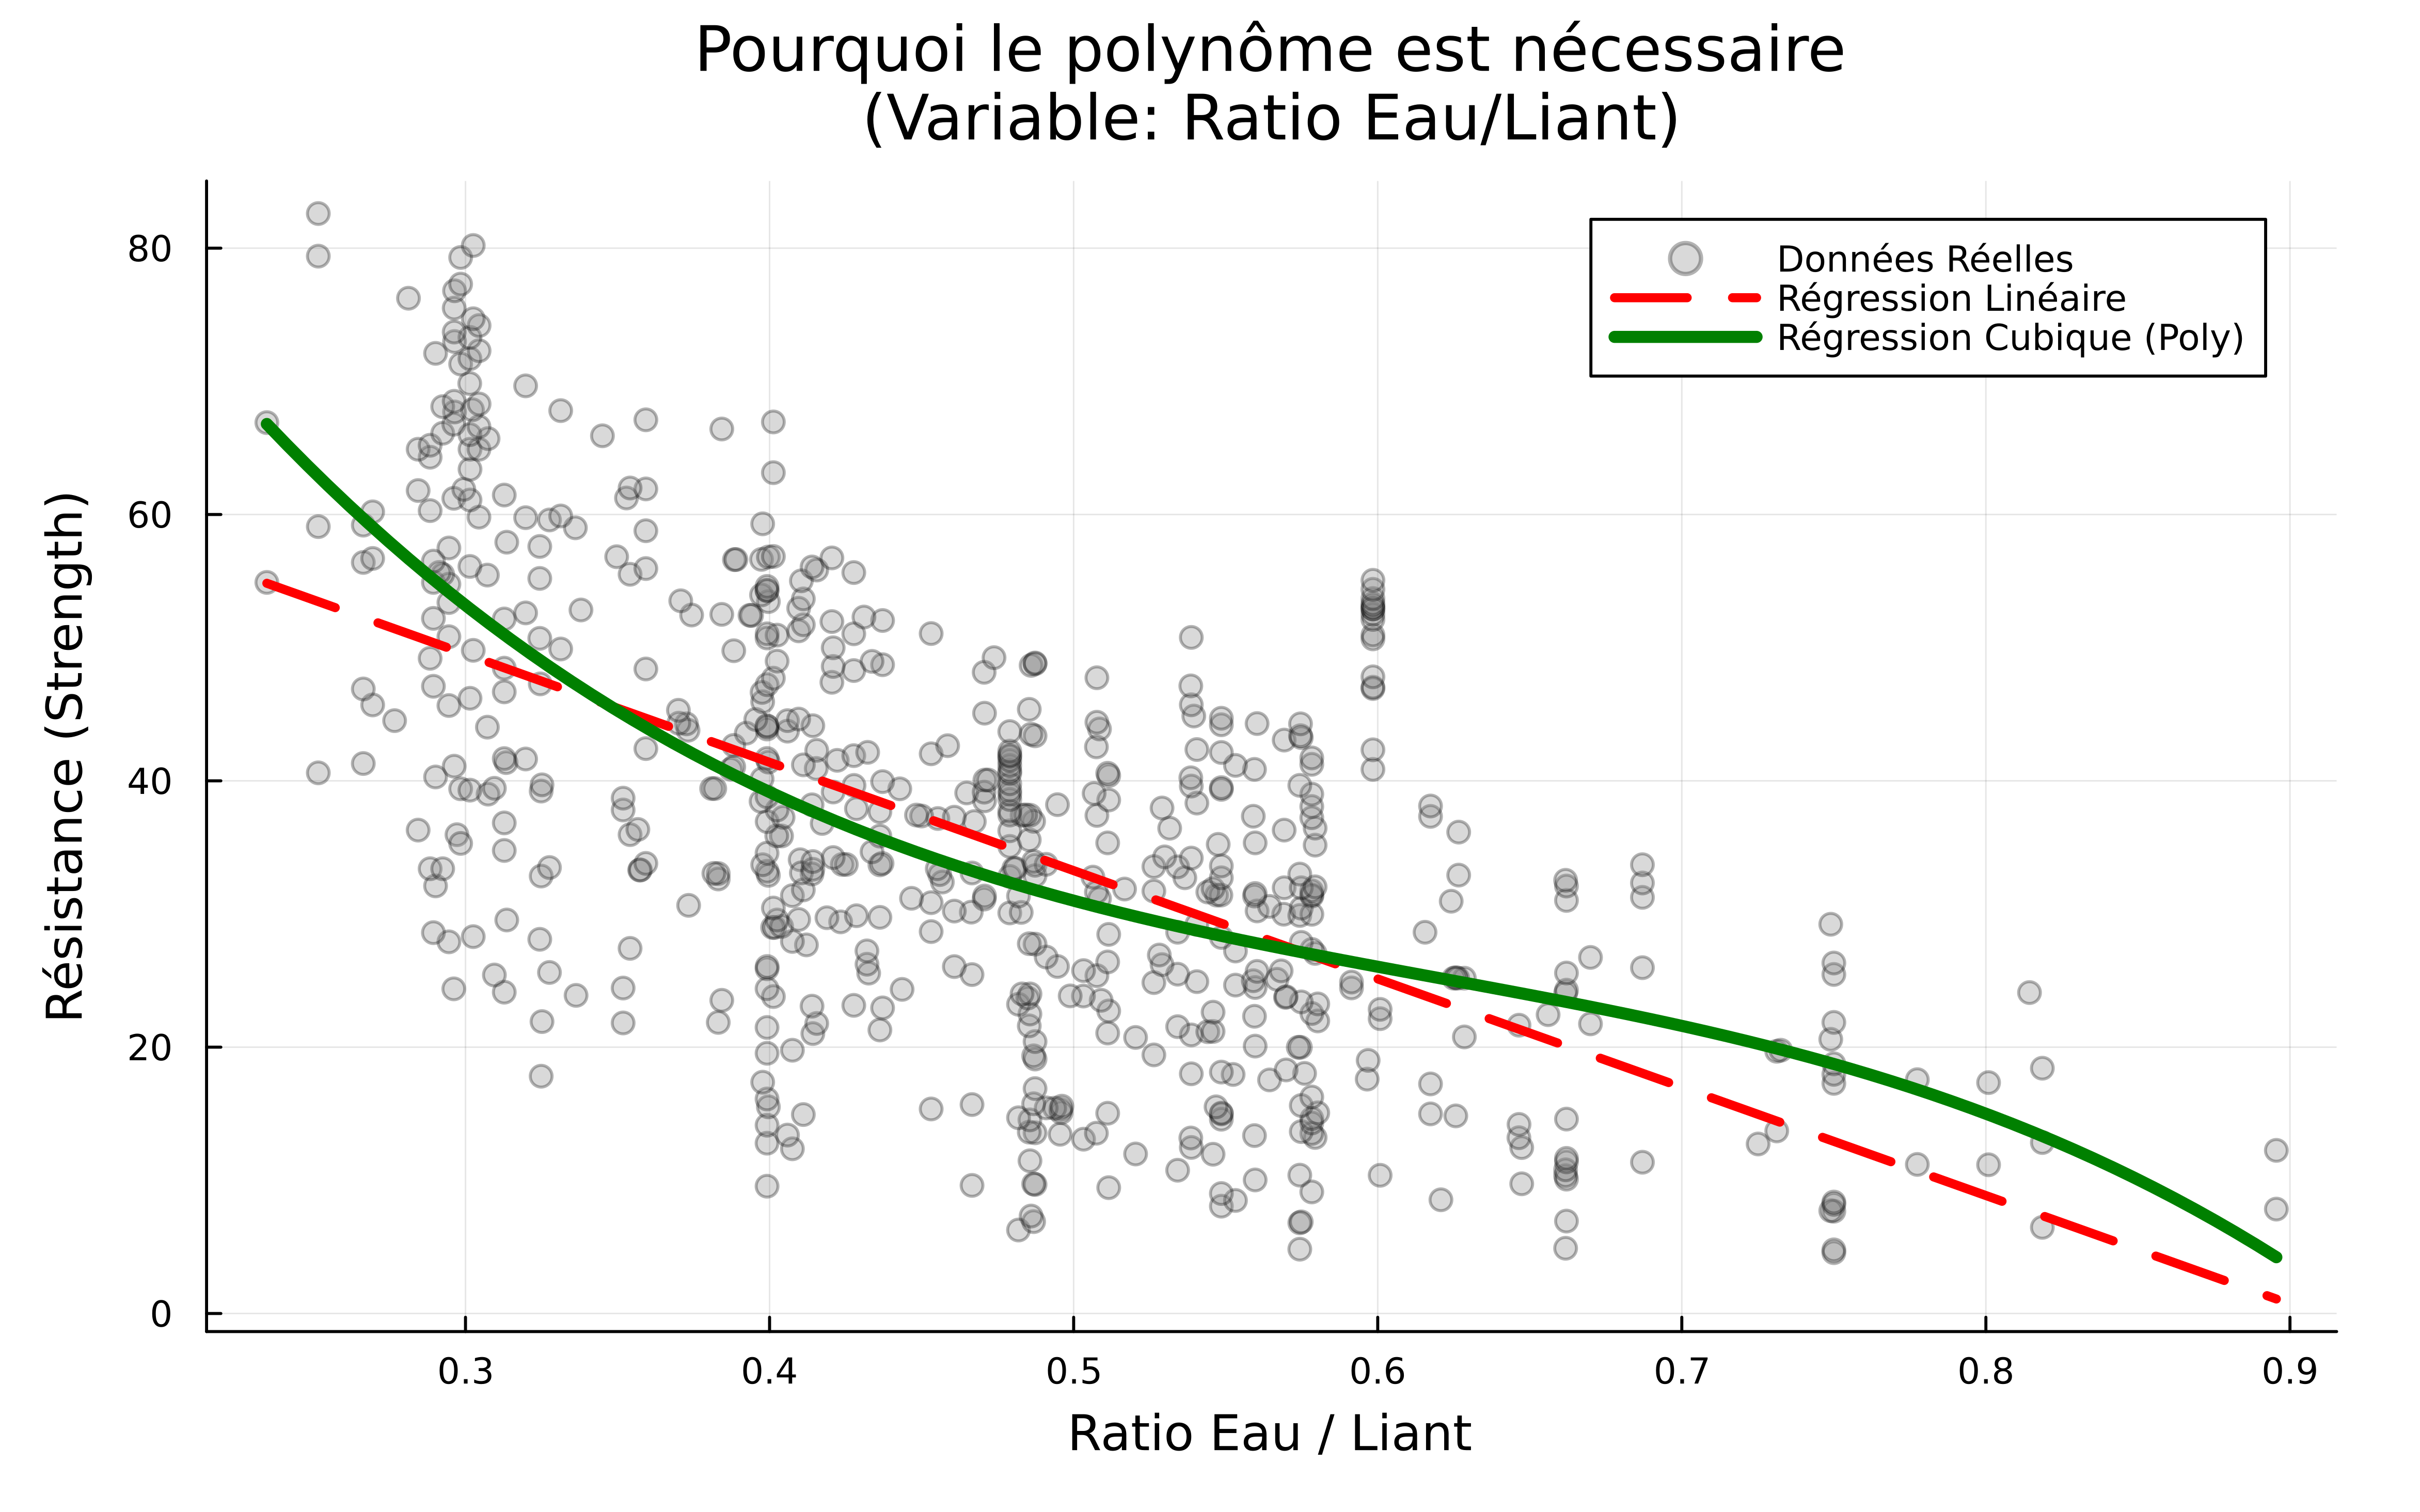

In [29]:

features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_phys = physics_transform(Matrix(df_train_clean[:, features]))
X_final_train = expand_poly(X_phys)
x_demo = X_phys[:, 9] 
y_demo = df_train_clean.Strength

df_demo = DataFrame(X=x_demo, Y=y_demo)
df_demo.X2 = x_demo .^ 2
df_demo.X3 = x_demo .^ 3


model_lin = lm(@formula(Y ~ X), df_demo)

model_poly = lm(@formula(Y ~ X + X2 + X3), df_demo)

x_range = range(minimum(x_demo), maximum(x_demo), length=100)
df_pred = DataFrame(X=x_range, X2=x_range.^2, X3=x_range.^3)

y_pred_lin = predict(model_lin, df_pred)
y_pred_poly = predict(model_poly, df_pred)

scatter(x_demo, y_demo, label="Données Réelles", alpha=0.3, color=:gray, title="Pourquoi le polynôme est nécessaire\n(Variable: Ratio Eau/Liant)")
plot!(x_range, y_pred_lin, label="Régression Linéaire", color=:red, linewidth=3, linestyle=:dash)
plot!(x_range, y_pred_poly, label="Régression Cubique (Poly)", color=:green, linewidth=4)

xlabel!("Ratio Eau / Liant")
ylabel!("Résistance (Strength)")

## 4.3 Génération de variables latentes (Clustering)

In [29]:
using CSV, DataFrames, LinearAlgebra, Statistics, Random

# ==========================================
# PARTIE 1 : ALGORITHMES 
# ==========================================

# --- A. Mise à l'échelle (Robust Scaler manuel) ---
# On centre sur la médiane et on divise par l'écart interquartile (IQR)
struct ManualScaler
    medians::Vector{Float64}
    iqrs::Vector{Float64}
end

function fit_scaler(X::Matrix)
    medians = vec(median(X, dims=1))
    # IQR = p75 - p25
    q25 = vec(map(col -> quantile(col, 0.25), eachcol(X)))
    q75 = vec(map(col -> quantile(col, 0.75), eachcol(X)))
    iqrs = q75 .- q25
    # Éviter la division par zéro
    iqrs[iqrs .== 0] .= 1.0
    return ManualScaler(medians, iqrs)
end

function transform_scale(scaler::ManualScaler, X::Matrix)
    return (X .- scaler.medians') ./ scaler.iqrs'
end

# --- B. Feature Engineering "Polynomial" Manuel ---
# Crée les termes quadratiques (x^2) et interactions (x*y)
function expand_poly(X)
    n, p = size(X)
    X_out = X
    # Carrés
    X_out = hcat(X_out, X.^2)
    # Cubes (Gardés car utiles pour la saturation)
    X_out = hcat(X_out, X.^3)
    # Interactions Doubles (Paires seulement)
    for i in 1:p, j in i+1:p
        X_out = hcat(X_out, X[:, i] .* X[:, j])
    end
    return hcat(ones(n), X_out)
end
# --- C. Régression Bayésienne (Algorithme "Evidence Approximation") ---
# C'est l'algo exact utilisé pour  BayesianRidge
function fit_bayesian_ridge(X, y; max_iter=300, tol=1e-3)
    n_samples, n_features = size(X)
    
    # Initialisation de alpha (précision du bruit) et lambda (précision des poids)
    alpha = 1.0 / var(y)
    lambda = 1.0
    
    XT_X = X' * X
    XT_y = X' * y
    
    w = zeros(n_features)
    eigen_vals = eigen(Symmetric(XT_X)).values # Valeurs propres pour optimiser le calcul
    
    for i in 1:max_iter
        # 1. Calcul de la Matrice de Covariance A posteriori (Sigma)
        # S^-1 = lambda * I + alpha * X^T * X
    
        A = lambda * I(n_features) + alpha * XT_X
        
        # 2. Calcul de la moyenne (w) : w = alpha * S * X^T * y
        # Résolution du système linéaire A * w = alpha * XT_y
        w_old = copy(w)
        w = A \ (alpha * XT_y)
        
        # 3. Mise à jour de gamma (nombre effectif de paramètres)
        # gamma = sum( (alpha * eig) / (lambda + alpha * eig) )
        gamma = sum((alpha .* eigen_vals) ./ (lambda .+ alpha .* eigen_vals))
        
        # 4. Mise à jour des hyperparamètres alpha et lambda
        # lambda = gamma / (w^T * w)
        lambda = gamma / (dot(w, w) + 1e-6)
        
        # alpha = (N - gamma) / sum((y - Xw)^2)
        residuals = y - X * w
        alpha = (n_samples - gamma) / (dot(residuals, residuals) + 1e-6)
        
        # Convergence ?
        if norm(w - w_old) < tol
            break
        end
    end
    
    return w
end

# --- D. GMM Simplifié (K-Means + Softmax) ---
# Pour simuler les variables latentes sans package lourd
function get_latent_probs(X_train, X_test, n_clusters; seed=42)
    Random.seed!(seed)
    n_samples = size(X_train, 1)
    
    # 1. Init: Choix aléatoire des centres
    centers = X_train[randperm(n_samples)[1:n_clusters], :]
    
    # 2. K-Means simplifié (10 itérations suffisent pour l'initialisation)
    for _ in 1:10
        # Assignation
        dists = [norm(X_train[i,:] - centers[k,:])^2 for i in 1:n_samples, k in 1:n_clusters]
        labels = [argmin(dists[i,:]) for i in 1:n_samples]
        
        # Update centers
        for k in 1:n_clusters
            mask = labels .== k
            if sum(mask) > 0
                centers[k,:] = mean(X_train[mask, :], dims=1)
            end
        end
    end
    
    # 3. Calcul "Soft" (Probabilités Gaussiennes basées sur la distance)
    # Proba ~ exp(-distance)
    function compute_probs(Data, C)
        dists = [norm(Data[i,:] - C[k,:]) for i in 1:size(Data,1), k in 1:size(C,1)]
        # Softmax inversé sur les distances
        exp_dists = exp.(-dists)
        sum_exps = sum(exp_dists, dims=2)
        return exp_dists ./ sum_exps
    end
    
    return compute_probs(X_train, centers), compute_probs(X_test, centers)
end


# ==========================================
# PARTIE 2 : EXÉCUTION DU PIPELINE
# ==========================================

println("Chargement...")


df_train = train_df_unique
df_test = test_df

# Extraction matrices
# Ordre des colonnes garanti par DataFrames
features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_raw = Matrix(df_train[:, features])
# Logarithme de la cible (Crucial)
y_log = log1p.(df_train.Strength) 

X_test_raw = Matrix(df_test[:, features])
ids_test = df_test.ID


function physics_transform(M::Matrix)
    # Base
    log_age = log.(M[:, 8] .+ 1)
    
    # Cinétique (Les interactions temporelles fortes)
    cem_age  = M[:, 1] .* log_age
    slag_age = M[:, 2] .* log_age
    
    # --- LES GAGNANTS DE TON ANALYSE ---
    
    # 1. W/B (Eau/Liant) -> Corrélation -0.615
    total_binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]
    w_b = M[:, 4] ./ (total_binder .+ 1.0)
    
    # 2. B/A (Liant/Agrégat) -> Corrélation +0.547 (ON LE GARDE !)
    total_agg = M[:, 6] .+ M[:, 7]
    b_a = total_binder ./ (total_agg .+ 1.0)
    
    # 3. Féret (Densité) -> Corrélation +0.524
    vol_cem = M[:, 1] ./ 3.15; vol_wat = M[:, 4] ./ 1.0
    feret = (vol_cem ./ (vol_cem .+ vol_wat)) .^ 2
    
    # 4. Golden Feature -> Corrélation +0.792 (LE BOSS)
    has_slag = Float64.(M[:, 2] .> 0)
    has_super = Float64.(M[:, 5] .> 0)
    golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
    
    # On jette C/F et Sup/Cem qui sont faibles
    
    # Retour : Base + LogAge + Les 4 Ratios Forts + 2 Cinétiques
    return hcat(M[:, 1:7], log_age, w_b, b_a, feret, golden, cem_age, slag_age)
end
println("Transformation Physique...")
X_phys = physics_transform(X_raw)
X_test_phys = physics_transform(X_test_raw)

# 2. Scaling Manuel
scaler = fit_scaler(X_phys)
X_scaled = transform_scale(scaler, X_phys)
X_test_scaled = transform_scale(scaler, X_test_phys)

# 3. Moyennage de Modèles (BMA) "Fait Main"
n_models = 100
preds_accum = zeros(size(X_test_scaled, 1))

println("Entraînement de $n_models modèles Bayésiens manuels...")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    # Nombre de clusters aléatoire entre 3 et 6
    k = rand(3:6)
    
    # On calcule les probabilités d'appartenance aux clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    # [Physique + Variables Latentes]
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale (Degré 2 pour éviter l'explosion combinatoire en manuel)
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne "From Scratch"
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédiction
    y_pred_log = X_poly_test * w
    preds_accum .+= expm1.(y_pred_log) # Retour à l'échelle
    
    if i % 5 == 0
        println("Modèle $i terminé...")
    end
end

final_preds = preds_accum ./ n_models

n_models = 100

# Accumulateurs pour le TEST (pour la soumission)
preds_accum_test = zeros(size(X_test_scaled, 1))

# Accumulateurs pour le TRAIN (pour calculer le RMSE final)
preds_accum_train = zeros(size(X_scaled, 1))

# Pour stocker les scores individuels
individual_rmses = Float64[]

println("\n=== Démarrage de l'entraînement de $n_models modèles ===")

for i in 1:n_models
    # A. Variables Latentes (GMM simplifié fait main)
    k = rand(3:6) # On varie le nombre de clusters
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    # B. Construction du dataset étendu
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    # C. Expansion Polynomiale
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    # D. Régression Bayésienne
    w = fit_bayesian_ridge(X_poly_train, y_log)
    
    # E. Prédictions (Sur Train et Test)
    # Sur Train (Pour le RMSE)
    y_pred_train_log = X_poly_train * w
    y_pred_train_real = expm1.(y_pred_train_log) # Retour à l'échelle réelle
    
    # Sur Test (Pour la soumission)
    y_pred_test_log = X_poly_test * w
    y_pred_test_real = expm1.(y_pred_test_log)
    
    # Accumulation pour la moyenne
    preds_accum_train .+= y_pred_train_real
    preds_accum_test  .+= y_pred_test_real
    
    # Calcul du RMSE de ce modèle spécifique
    # On compare la prédiction à la vraie force (expm1(y_log))
    y_true_real = expm1.(y_log)
    rmse_iter = sqrt(mean((y_pred_train_real .- y_true_real).^2))
    push!(individual_rmses, rmse_iter)
    
    println("Modèle $i (Clusters=$k) -> RMSE Train : $(round(rmse_iter, digits=4))")
end

# --- Calcul du résultat Final ---

# Moyenne des prédictions
final_preds_train = preds_accum_train ./ n_models
final_preds_test = preds_accum_test ./ n_models

# RMSE de l'Ensemble (Le score qui compte vraiment)
y_true_real = expm1.(y_log)
ensemble_rmse = sqrt(mean((final_preds_train .- y_true_real).^2))

println("\n=== RÉSULTATS ===")
println("RMSE Moyen des modèles individuels : $(round(mean(individual_rmses), digits=4))")
println("RMSE de l'Ensemble (Bagging)       : $(round(ensemble_rmse, digits=4))")
println("Gain grâce au moyennage            : $(round(mean(individual_rmses) - ensemble_rmse, digits=4)) points")

if ensemble_rmse < 5.0
    println("✅ OBJECTIF ATTEINT : Le modèle apprend avec une précision < 5 RMSE !")
else
    println("⚠️  ATTENTION : Le modèle est encore au-dessus de 5.")
end

# Sauvegarde
println("\nSauvegarde du fichier de soumission...")
df_sub = DataFrame(ID = ids_test, Strength = final_preds_test)
df_sub.Strength = max.(df_sub.Strength, 0.0)

CSV.write("submission_bayes_ridge_plus_data.csv", df_sub)
println("Terminé ! Fichier : submission_julia_manual_monitored.csv")

Chargement...
Transformation Physique...
Entraînement de 100 modèles Bayésiens manuels...
Modèle 5 terminé...
Modèle 10 terminé...
Modèle 15 terminé...
Modèle 20 terminé...
Modèle 25 terminé...
Modèle 30 terminé...
Modèle 35 terminé...
Modèle 40 terminé...
Modèle 45 terminé...
Modèle 50 terminé...
Modèle 55 terminé...
Modèle 60 terminé...
Modèle 65 terminé...
Modèle 70 terminé...
Modèle 75 terminé...
Modèle 80 terminé...
Modèle 85 terminé...
Modèle 90 terminé...
Modèle 95 terminé...
Modèle 100 terminé...

=== Démarrage de l'entraînement de 100 modèles ===
Modèle 1 (Clusters=4) -> RMSE Train : 4.2946
Modèle 2 (Clusters=5) -> RMSE Train : 4.2927
Modèle 3 (Clusters=3) -> RMSE Train : 4.3296
Modèle 4 (Clusters=5) -> RMSE Train : 4.3278
Modèle 5 (Clusters=4) -> RMSE Train : 4.2959
Modèle 6 (Clusters=3) -> RMSE Train : 4.3292
Modèle 7 (Clusters=3) -> RMSE Train : 4.402
Modèle 8 (Clusters=5) -> RMSE Train : 4.3232
Modèle 9 (Clusters=3) -> RMSE Train : 4.3291
Modèle 10 (Clusters=5) -> RMSE Tra